# RVIB

### Processes

In [78]:

import numpy as np

# ---------------------------------------------------------------------------
# Utility for seeded RNG -----------------------------------------------------
# ---------------------------------------------------------------------------
def _rng(seed):          # convenience
    return np.random.default_rng(seed)

# ---------------------------------------------------------------------------
# 0-memory (IID) -------------------------------------------------------------
# ---------------------------------------------------------------------------
def iid(p_one=0.5):
    """Factory → generator for an IID(p) coin.   Cμ = 0."""
    def _gen(n, *, seed=0):
        return _rng(seed).choice([0, 1], size=n, p=[1 - p_one, p_one])
    _gen.__name__ = f"IID(p={p_one})"
    return _gen

# ---------------------------------------------------------------------------
# 1-bit Markov ---------------------------------------------------------------
# ---------------------------------------------------------------------------
def two_state_markov(p01=0.2, p10=0.8):
    """
    Two-state Markov chain
         0 --p01--> 1,   1 --p10--> 0.
    Memory = 1 bit,  Cμ ≈ H(π) where π is stationary.
    """
    def _gen(n, *, seed=0):
        rng = _rng(seed)
        seq = np.empty(n, int)
        seq[0] = rng.integers(2)
        for t in range(1, n):
            seq[t] = 1 if (seq[t-1]==0 and rng.random()<p01) \
                         else 0 if (seq[t-1]==1 and rng.random()<p10) \
                         else seq[t-1]
        return seq
    return _gen

# ---------------------------------------------------------------------------
# Sofic processes (forbidden-word constraints) -------------------------------
# ---------------------------------------------------------------------------
def golden_mean(p_01=0.5):
    """Golden-Mean: “11” forbidden.  Cμ = 1 bit."""
    def _gen(n, *, seed=0):
        rng = _rng(seed); seq = np.empty(n, int); seq[0] = rng.integers(2)
        for t in range(1, n):
            seq[t] = 0 if seq[t-1]==1 else (1 if rng.random()<p_01 else 0)
        return seq
    return _gen

def even_process(p_10=0.5):
    """
    Even process: blocks of 0s between successive 1s have even length.
    Minimal ε-machine has two states,  Cμ = 1 bit.
    """
    def _gen(n, *, seed=0):
        rng = _rng(seed); seq = np.empty(n, int); even=True
        for t in range(n):
            if even:
                if rng.random()<p_10: seq[t]=1
                else: seq[t]=0; even=False
            else:         seq[t]=0; even=True
        return seq
    return _gen

def no_three_ones():
    """(3,∞)-RLL: forbid “111”.  ε-machine has three states,  Cμ ≈ 1.37 bits."""
    def _gen(n, *, seed=0):
        rng=_rng(seed); seq=np.empty(n,int); seq[:2]=rng.integers(2,size=2)
        for t in range(2,n):
            if seq[t-1]==seq[t-2]==1: seq[t]=0
            else: seq[t]=rng.integers(2)
        return seq
    return _gen


# ---------------------------------------------------------------------------
# Renewal / alternating processes -------------------------------------------
# ---------------------------------------------------------------------------
def alternating_blocks(p_geometric=0.5):
    """
    Geometric-renewal alternating 000…111…  blocks.
    Mean block length 1/p.  Unifilar, infinite state support,  Cμ = ∞ in limit
    but finite for truncated windows.  Good “high-complexity” foil.
    """
    def _gen(n, *, seed=0):
        rng=_rng(seed); seq=[]; symbol=0
        while len(seq)<n:
            block_len = rng.geometric(p_geometric)
            seq.extend([symbol]*block_len)
            symbol ^= 1
        return np.array(seq[:n],int)
    return _gen

# ---------------------------------------------------------------------------
# Deterministic automatic sequences (aperiodic, infinite memory) ------------
# ---------------------------------------------------------------------------
def thue_morse():
    """
    Deterministic Thue-Morse sequence: iterative morphism 0→01, 1→10.
    Has logarithmically growing Cμ.  Useful extreme for deterministic complexity.
    """
    def _gen(n, *, seed=0):          # seed ignored (deterministic)
        seq = [0]
        while len(seq) < n:
            seq += [1-x for x in seq]
        return np.array(seq[:n], int)
    return _gen

# ---------------------------------------------------------------------------
# Factory dictionary ---------------------------------------------------------
# ---------------------------------------------------------------------------
PROCESSES = {
    # zero/low complexity
    "IID(p=0.5)"         : iid(0.5),
    "IID(p=0.25)"        : iid(0.25),
    "Two-state Markov"   : two_state_markov(0.3, 0.7),

    # sofic / finite-state ε-machines
    "Golden-Mean"        : golden_mean(),
    "Even"               : even_process(),
    "No-Three-Ones"      : no_three_ones(),

    # high / unbounded complexity
    "Alternating Geom p=0.3": alternating_blocks(0.3),
    "Thue-Morse"             : thue_morse(),
}

if __name__ == "__main__":
    # quick demo: generate and print first 40 symbols for each process
    np.set_printoptions(threshold=40, linewidth=120)
    for name, gen in PROCESSES.items():
        print(f"{name:>20}: {gen(40, seed=1)}")

          IID(p=0.5): [1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0]
         IID(p=0.25): [0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0]
    Two-state Markov: [0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1]
         Golden-Mean: [0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0]
                Even: [0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0]
       No-Three-Ones: [0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0]
Alternating Geom p=0.3: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0]
          Thue-Morse: [0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0]


# Eigenvalue approach

/var/folders/w9/nnxpfc5n24nd6dr0m99mr75c0000gp/T/ipykernel_17594/4146321767.py:93: RuntimeWarning: divide by zero encountered in matmul
  cov = (weights[:, None] * diffs).T @ diffs                # A × A
/var/folders/w9/nnxpfc5n24nd6dr0m99mr75c0000gp/T/ipykernel_17594/4146321767.py:93: RuntimeWarning: overflow encountered in matmul
  cov = (weights[:, None] * diffs).T @ diffs                # A × A
/var/folders/w9/nnxpfc5n24nd6dr0m99mr75c0000gp/T/ipykernel_17594/4146321767.py:93: RuntimeWarning: invalid value encountered in matmul
  cov = (weights[:, None] * diffs).T @ diffs                # A × A



=== IID(p=0.5) ===
Final β           : 100.00
Final #states     : 2
Emission probabilities  p(future | state):
  State S0: [0.19973845 0.31541463 0.22439289 0.26045403]
  State S1: [0.30523437 0.18249349 0.27738573 0.23488641]

=== IID(p=0.25) ===
Final β           : 100.00
Final #states     : 2
Emission probabilities  p(future | state):
  State S0: [0.59493917 0.20534074 0.16402492 0.03569517]
  State S1: [0.55140198 0.16920688 0.20183762 0.07755352]

=== Two-state Markov ===
Final β           : 100.00
Final #states     : 3
Emission probabilities  p(future | state):
  State S0: [0.6199948  0.24244379 0.12187092 0.01569049]
  State S1: [0.48407294 0.20958326 0.17287926 0.13346455]
  State S2: [0.46254962 0.20397666 0.26228274 0.07119099]

=== Golden-Mean ===
Final β           : 100.00
Final #states     : 2
Emission probabilities  p(future | state):
  State S0: [0.49610662 0.50389338 0.         0.        ]
  State S1: [0.24941777 0.24889189 0.50169033 0.        ]

=== Even ===
Final β 

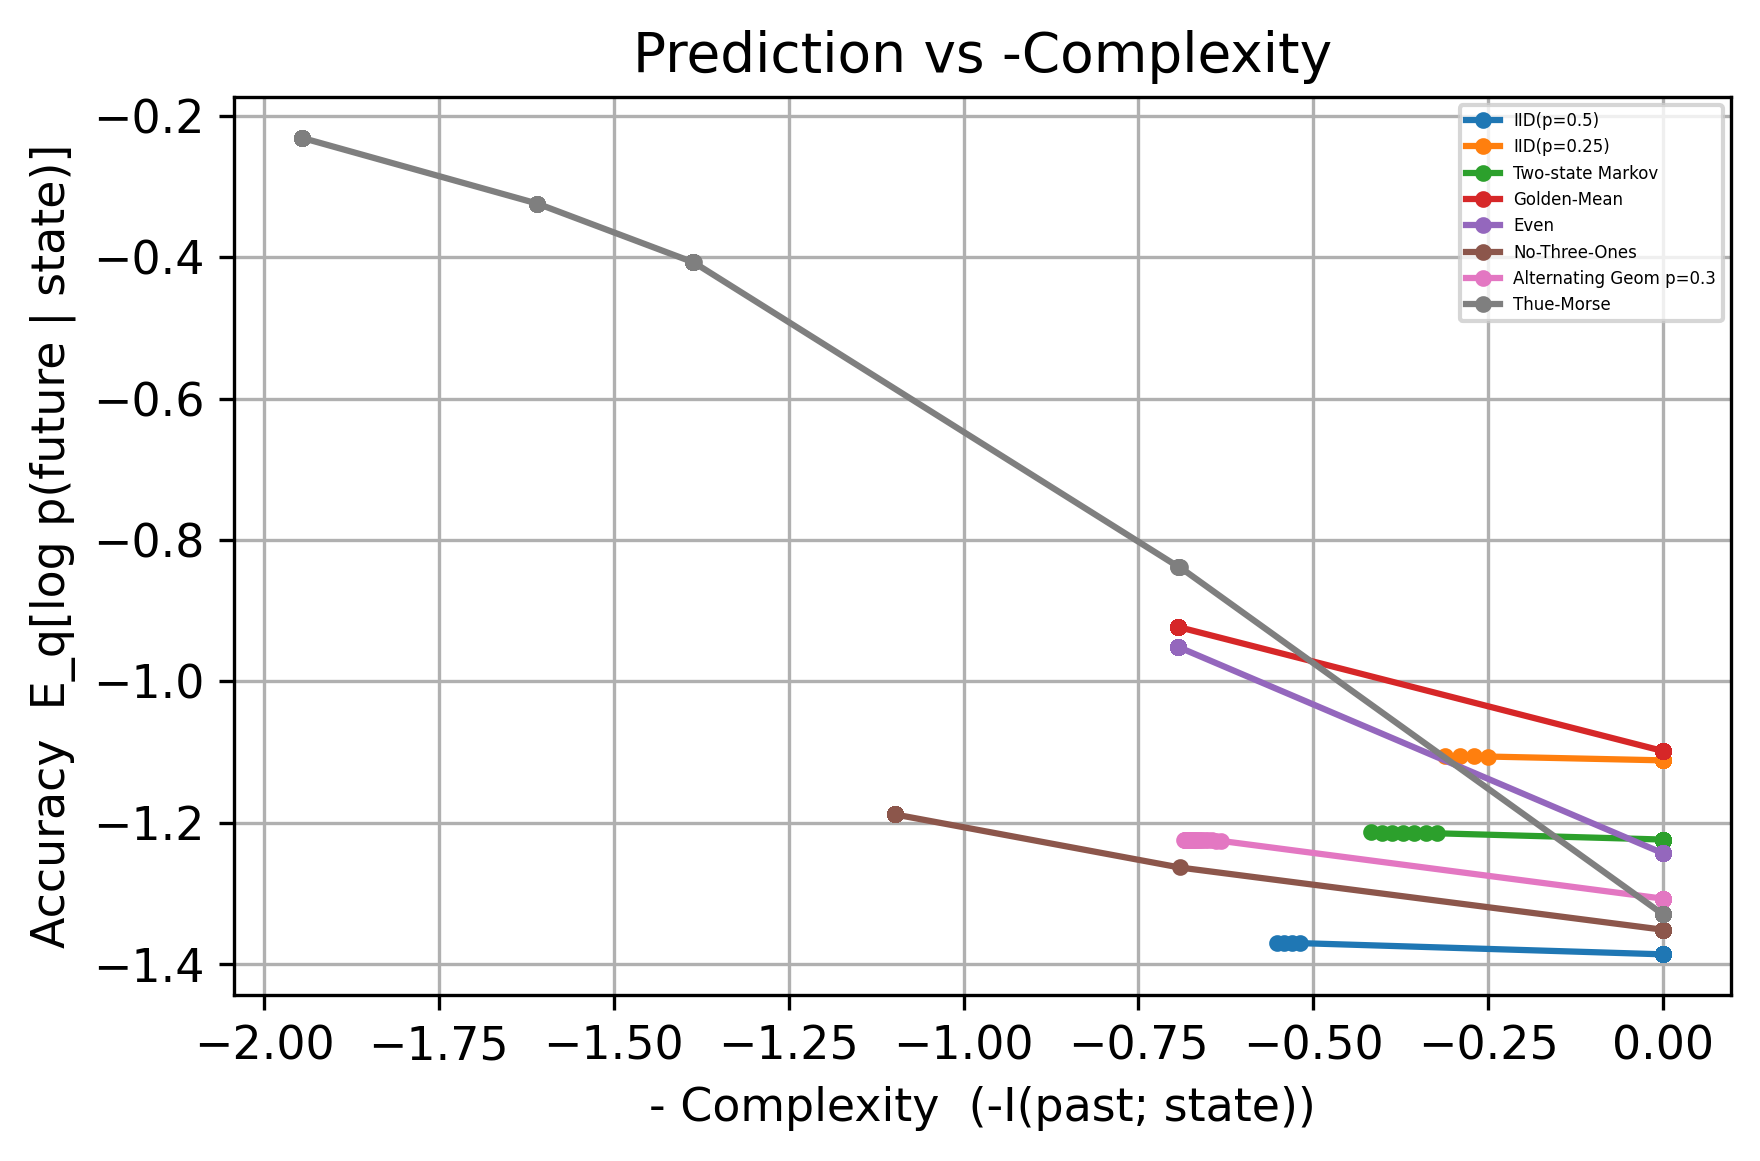

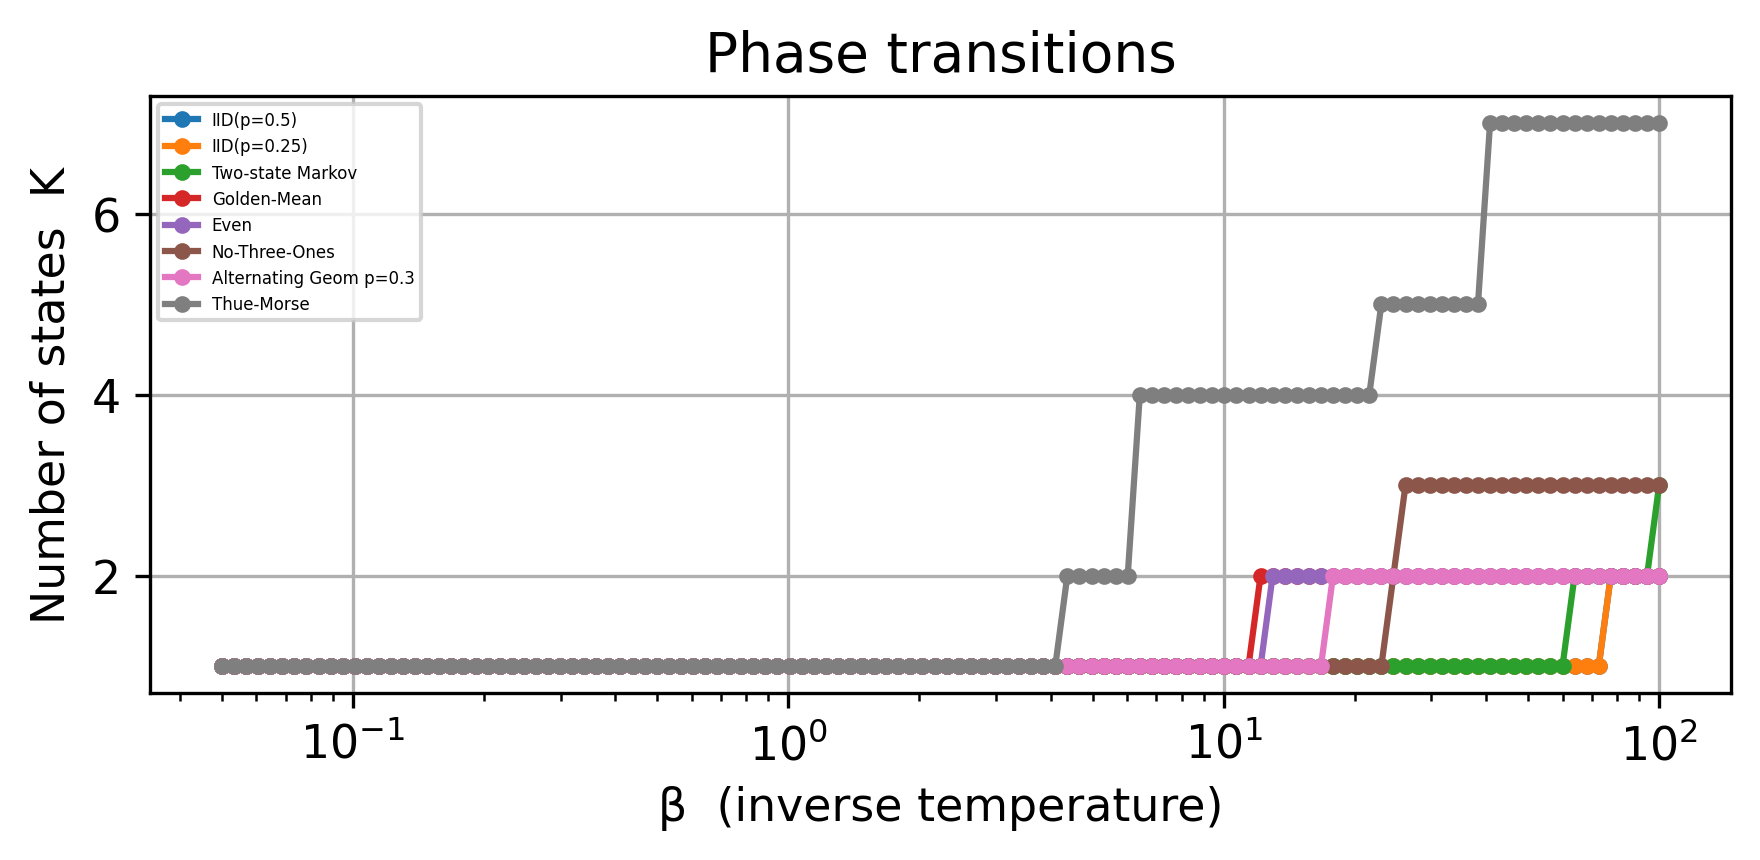

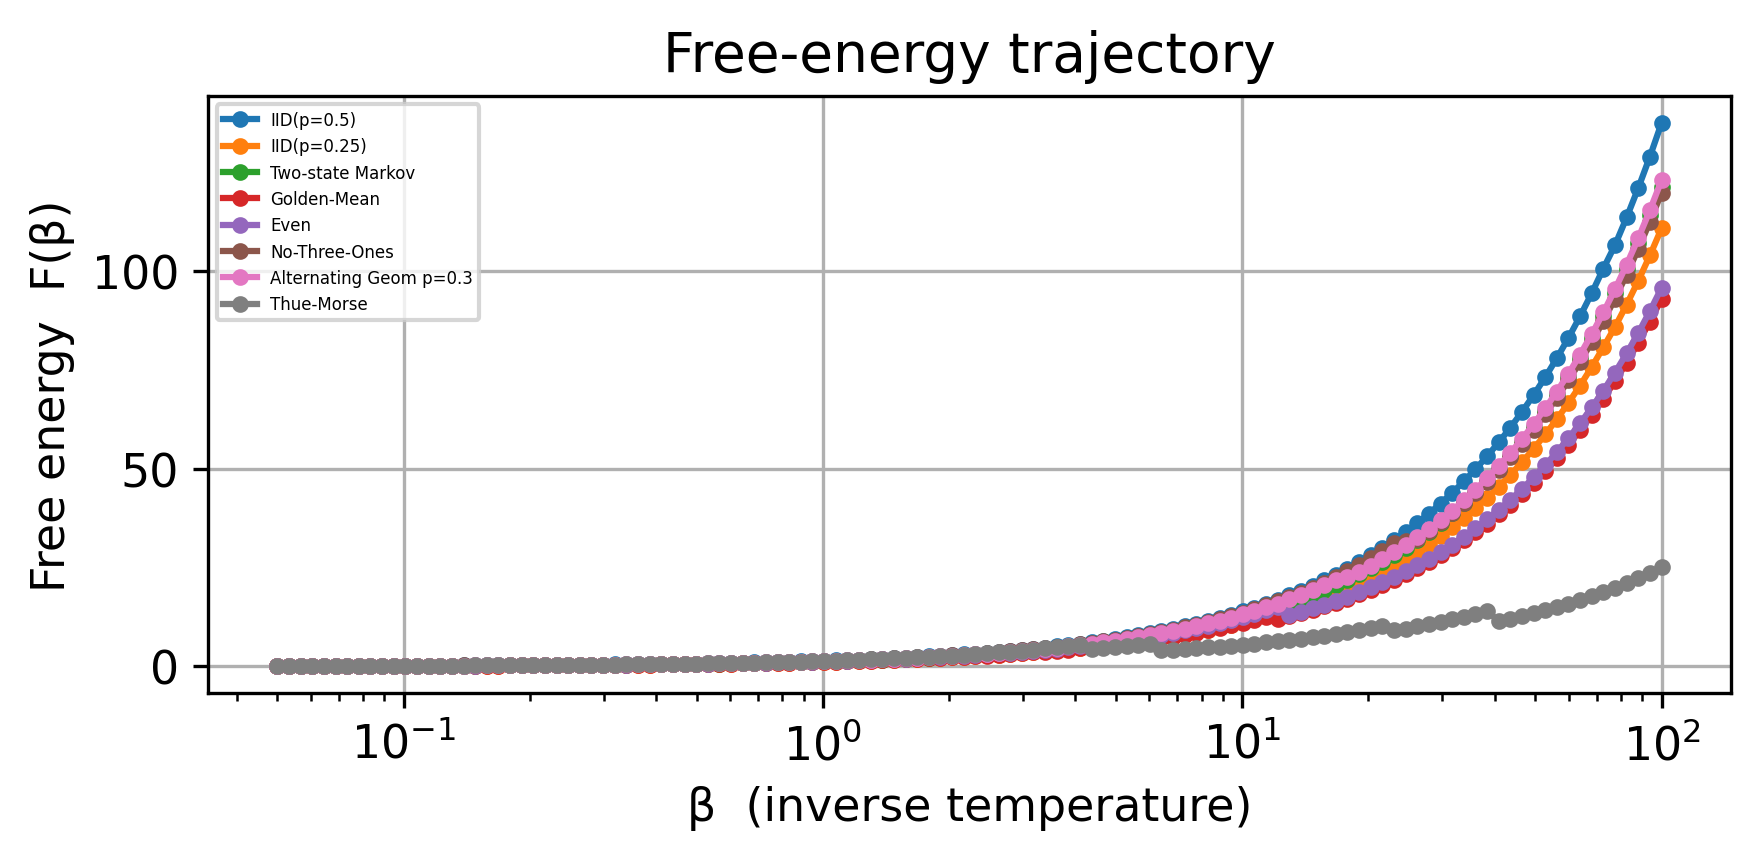

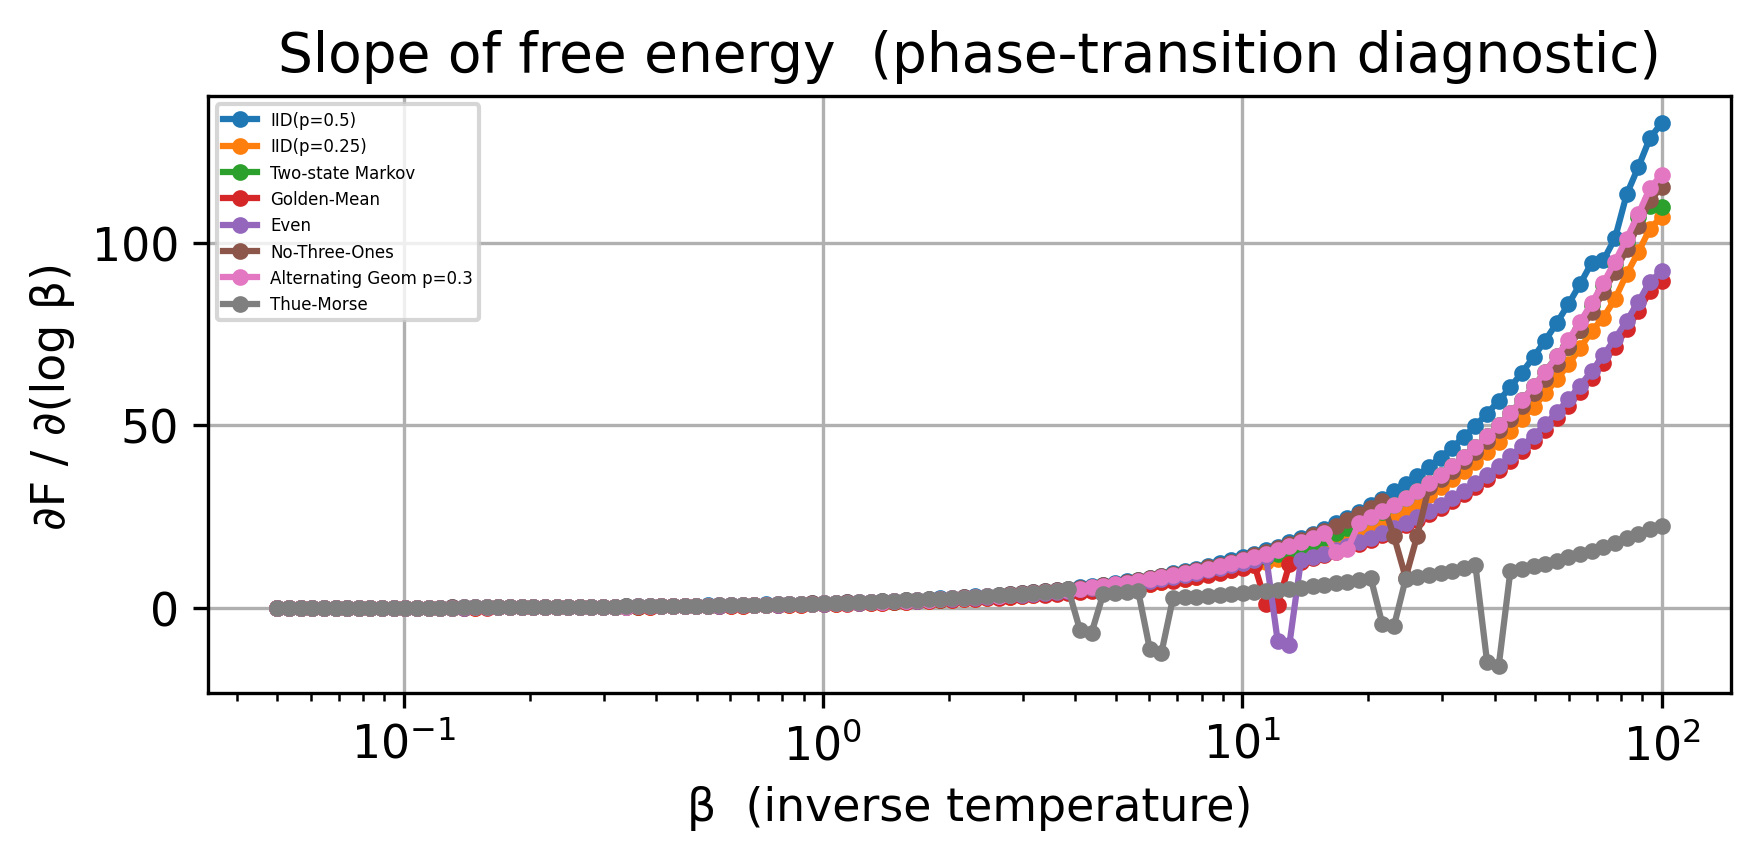


Running extended sanity checks …
  IID(p=0.5)                 ✓ OK
  IID(p=0.25)                ✓ OK
  Two-state Markov           ✓ OK
  Golden-Mean                ✓ OK
  Even                       ✓ OK
  No-Three-Ones              ✓ OK
  Alternating Geom p=0.3     ✗ run-length CV too small; not heavy-tailed


AssertionError: run-length CV too small; not heavy-tailed

In [98]:
"""
Publication-ready Information-Bottleneck implementation
with automatic state growth (Still 2014 style).

Features
========
1.  Synthetic sources: IID, Golden-Mean, Even.
2.  Deterministic-annealing over a fine β schedule.
3.  Automatic splitting of states when it lowers free energy.
4.  Three high-dpi plots:
      • Trade-off curve: accuracy vs –complexity
      • Phase transitions: β vs number of states K(β)
      • Free-energy trajectory: β vs F(β)
5.  Sanity checks for each source.
6.  Plain-English snake-case variable names.
"""

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
plt.rcParams.update({'legend.fontsize': 4})

# ------------------------------------------------------------
# 0.  Hyper-parameters
# ------------------------------------------------------------
past_window           = 10
future_window         = 2
alphabet_size         = 2 ** future_window
sample_length         = 20_0000
beta_schedule         = np.geomspace(0.05, 100, 120)  # 60 β’s
max_states_allowed    = 16
minimum_delta_free_E  = 0.01
em_max_iterations     = 400
em_convergence_tol    = 1e-6
random_seed           = 42

# ------------------------------------------------------------
# 1.  Synthetic source processes
# ------------------------------------------------------------

sources = {name: gen(20_000, seed=123) for name, gen in PROCESSES.items()}

# ------------------------------------------------------------
# 2.  Empirical p(future | past)
# ------------------------------------------------------------
def empirical_future_given_past(sequence, L_past=past_window, L_future=future_window):
    frequency   = defaultdict(lambda: np.zeros(alphabet_size, int))
    past_counts = defaultdict(int)
    for t in range(L_past, len(sequence) - L_future + 1):
        past_idx   = int(''.join(map(str, sequence[t-L_past:t])), 2)
        future_idx = int(''.join(map(str, sequence[t:t+L_future])), 2)
        frequency[past_idx][future_idx] += 1
        past_counts[past_idx]           += 1
    past_words = sorted(frequency)
    past_prob  = np.array([past_counts[p] for p in past_words], float); past_prob /= past_prob.sum()
    future_conditional = np.array([frequency[p] / frequency[p].sum() for p in past_words])
    return past_words, past_prob, future_conditional

# ------------------------------------------------------------
# 3.  Free-energy helpers
# ------------------------------------------------------------
def kl_divergence(p, q, eps=1e-12):
    p, q = np.clip(p, eps, 1), np.clip(q, eps, 1)
    return np.sum(p * np.log(p / q))

def compute_free_energy(past_prob, posterior, emission, beta, future_conditional):
    num_states = posterior.shape[1]
    complexity = np.sum(
        past_prob[:, None] * posterior *
        (np.log(posterior + 1e-12) + np.log(num_states))
    )
    accuracy = np.sum(
        past_prob[:, None, None] * posterior[:, :, None] *
        future_conditional[:, None, :] *
        np.log(emission[None, :, :] + 1e-12)
    )
    return complexity - beta * accuracy, complexity, accuracy

def _largest_eigenvalue(state_id,
                        past_prob,
                        posterior,
                        emission,
                        future_conditional):
    """
    Compute λ_max of Σ_k  = ∑_i  P(past=i) q(s=k|i) ( r_i - r_k )( r_i - r_k )ᵀ
    where r_i = P(future | past=i)  and  r_k = emission[k].
    This is the Hessian of F w.r.t. perturbations inside state k.
    """
    diffs   = future_conditional - emission[state_id]        # shape (N_past , A)
    weights = past_prob * posterior[:, state_id]              # shape (N_past,)

    # weighted covariance in the simplex (full matrix is small: A × A )
    cov = (weights[:, None] * diffs).T @ diffs                # A × A
    # use symmetric eigensolver (all values real)
    return np.linalg.eigvalsh(cov).max()

def em_coordinate_ascent(past_prob, future_conditional, beta,
                         init_emission=None, init_posterior=None,
                         max_iter=em_max_iterations, tol=em_convergence_tol,
                         seed=random_seed):
    rng         = np.random.default_rng(seed)
    num_states  = init_emission.shape[0] if init_emission is not None else 1
    emission    = init_emission if init_emission is not None else rng.random((num_states, alphabet_size))
    emission   /= emission.sum(1, keepdims=True)
    posterior   = init_posterior if init_posterior is not None else np.full((len(past_prob), num_states), 1/num_states)

    for _ in range(max_iter):
        # E-step
        distance = np.array([[kl_divergence(future_conditional[i], emission[k])
                              for k in range(num_states)]
                             for i in range(len(past_prob))])
        posterior = np.exp(-beta * distance); posterior /= posterior.sum(1, keepdims=True)
        # M-step
        weights   = past_prob[:, None] * posterior
        emission_new = (weights[:, :, None] * future_conditional[:, None, :]).sum(0)
        emission_new /= emission_new.sum(1, keepdims=True)
        if np.max(np.abs(emission_new - emission)) < tol:
            emission = emission_new; break
        emission = emission_new

    free_E, complexity, accuracy = compute_free_energy(
        past_prob, posterior, emission, beta, future_conditional)
    return posterior, emission, free_E, complexity, accuracy

# ------------------------------------------------------------
# 4.  One-step split (entropy heuristic)
# ------------------------------------------------------------
def attempt_state_split(past_prob, future_conditional, beta,
                        posterior, emission, free_E_old,
                        delta_F_minimum=minimum_delta_free_E,
                        seed=random_seed):
    """
    Proper Still-style split:
      • compute λ_max for every state,
      • pick the one where  β·λ_max  is largest,
      • split only if  β·λ_max  > 1   (linear instability)  *and*
        the new free energy really drops (safety check).
    """
    current_states = emission.shape[0]
    if current_states >= max_states_allowed:
        return posterior, emission, free_E_old, False

    # --- eigenvalue test for each state ---------------------------------
    lambda_max = [
        _largest_eigenvalue(k, past_prob, posterior, emission, future_conditional)
        for k in range(current_states)
    ]
    k_to_split = int(np.argmax(lambda_max))
    if beta * lambda_max[k_to_split] <= 1.0:          # no instability ⇒ stop
        return posterior, emission, free_E_old, False

    # --------------------------------------------------------------------
    rng = np.random.default_rng(seed)
    perturb = rng.normal(scale=1e-2, size=emission[k_to_split].shape)
    new_vec = np.clip(emission[k_to_split] + perturb, 1e-6, None)
    new_vec /= new_vec.sum()

    new_emission = np.vstack([emission, new_vec[None, :]])
    new_posterior           = np.pad(posterior, ((0, 0), (0, 1)), 'constant')
    new_posterior[:, -1]    = new_posterior[:, k_to_split] * 0.5
    new_posterior[:, k_to_split] *= 0.5
    new_posterior          /= new_posterior.sum(1, keepdims=True)

    post_new, emit_new, free_E_new, *_ = em_coordinate_ascent(
        past_prob, future_conditional, beta,
        init_emission=new_emission, init_posterior=new_posterior,
        seed=seed)

    # optional free-energy safeguard
    if free_E_old - free_E_new > delta_F_minimum:
        return post_new, emit_new, free_E_new, True
    return posterior, emission, free_E_old, False

# ------------------------------------------------------------
# 5.  Main loop: annealing with automatic splits
# ------------------------------------------------------------
# 5.  Main loop: annealing with automatic splits
# ----------------------------------------------
plt.rcParams.update({'font.size': 11})
fig_trade, ax_trade = plt.subplots(figsize=(6, 4), dpi=300)
fig_phase, ax_phase = plt.subplots(figsize=(6, 3), dpi=300)
fig_free,  ax_free  = plt.subplots(figsize=(6, 3), dpi=300)
fig_grad,  ax_grad  = plt.subplots(figsize=(6, 3), dpi=300)   # NEW

for label, sequence in sources.items():
    past_words, past_prob, future_cond = empirical_future_given_past(sequence)

    neg_complexity, accuracy = [], []
    state_counts, free_E, dF_dBeta = [], [], []                # NEW list

    posterior = emission = None

    for beta in beta_schedule:
        posterior, emission, F, C, A = em_coordinate_ascent(
            past_prob, future_cond, beta,
            init_emission=emission, init_posterior=posterior
        )
        while True:
            posterior, emission, F, split_ok = attempt_state_split(
                past_prob, future_cond, beta,
                posterior, emission, F)
            if not split_ok: break

        neg_complexity.append(-C)
        accuracy.append(A)
        state_counts.append(emission.shape[0])
        free_E.append(F)

    # --- finite-difference slope in log-β space --------------------------
    # use log β so spacing is uniform
    log_beta = np.log(beta_schedule)
    dF_dBeta = np.gradient(free_E, log_beta)

    # -------- plots ------------------------------------------------------
    ax_trade.plot(neg_complexity, accuracy, '-o', ms=3, label=label)
    ax_phase.plot(beta_schedule, state_counts, '-o', ms=3, label=label)
    ax_free .plot(beta_schedule, free_E, '-o', ms=3, label=label)
    ax_grad .plot(beta_schedule, dF_dBeta, '-o', ms=3, label=label)   # NEW

    for ax in (ax_trade, ax_phase, ax_free, ax_grad):
        ax.legend(fontsize=4)                                          # tidy legends

    # -------- console prints --------------------------------------------
    print(f"\n=== {label} ===")
    print(f"Final β           : {beta_schedule[-1]:.2f}")
    print(f"Final #states     : {emission.shape[0]}")
    print("Emission probabilities  p(future | state):")
    for idx, vec in enumerate(emission):
        print(f"  State S{idx}: {vec}")

# -------- beautify plots -------------------------------------------------
ax_trade.set(
    xlabel='- Complexity  (-I(past; state))',
    ylabel='Accuracy  E_q[log p(future | state)]',
    title ='Prediction vs -Complexity')
ax_trade.grid(True)

ax_phase.set_xscale('log')
ax_phase.set(
    xlabel='β  (inverse temperature)',
    ylabel='Number of states  K',
    title ='Phase transitions')
ax_phase.grid(True)

ax_free.set_xscale('log')
ax_free.set(
    xlabel='β  (inverse temperature)',
    ylabel='Free energy  F(β)',
    title ='Free-energy trajectory')
ax_free.grid(True)

ax_grad.set_xscale('log')
ax_grad.set(
    xlabel='β  (inverse temperature)',
    ylabel='∂F / ∂(log β)',
    title ='Slope of free energy  (phase-transition diagnostic)')
ax_grad.grid(True)

fig_trade.tight_layout(); fig_phase.tight_layout()
fig_free.tight_layout();   fig_grad.tight_layout()
plt.show()

# ------------------------------------------------------------
# 6.  Sanity checks for *all* library processes
# ------------------------------------------------------------
def check_iid(sequence, target_p, tol=0.02):
    p_hat = sequence.mean()
    assert abs(p_hat - target_p) < tol, f"IID p̂={p_hat:.3f} ≠ {target_p}"

def check_no_word(sequence, word):
    bitstring = ''.join(map(str, sequence))
    assert word not in bitstring, f'forbidden word "{word}" appeared'

def check_even(sequence):
    runs = ''.join(map(str, sequence)).split('1')
    assert all(len(r) % 2 == 0 for r in runs), "odd-length 0-block found"


def check_markov(sequence, tol=0.05):
    runs = np.diff(np.where(np.diff(sequence)!=0)[0]+1)
    cv   = runs.std() / runs.mean()
    assert cv > tol, "Markov chain looks memory-less"     # simple but robust

def check_noisy_copy(sequence, underlying, eps, tol=0.02):
    flip_rate = (sequence != underlying).mean()
    assert abs(flip_rate - eps) < tol, f"flip-rate {flip_rate:.3f} ≠ ε={eps}"

def check_alternating(sequence, tol=0.1):
    runs = np.diff(np.where(np.diff(sequence)!=0)[0]+1)
    cv   = runs.std() / runs.mean()
    assert cv > 1+tol, "run-length CV too small; not heavy-tailed"

def check_thue_morse(sequence):
    blocks = {tuple(sequence[i:i+4]) for i in range(0, 1024-3)}
    assert len(blocks) == 16, "Thue-Morse missing some length-4 blocks"

# map generator names → test
sanity_dispatch = {
    "IID(p=0.5)"       : lambda s: check_iid(s, 0.5),
    "IID(p=0.25)"      : lambda s: check_iid(s, 0.25),
    "Two-state Markov" : check_markov,
    "Golden-Mean"      : lambda s: check_no_word(s, "11"),
    "Even"             : check_even,
    "No-Three-Ones"    : lambda s: check_no_word(s, "111"),
    "Alternating Geom p=0.3": check_alternating,
    "Thue-Morse"       : check_thue_morse,
}

print("\nRunning extended sanity checks …")
for proc_name, gen in PROCESSES.items():
    try:
        sample = gen(4096, seed=99)        # small sample is enough
        sanity_dispatch[proc_name](sample)
        print(f"  {proc_name:<25}  ✓ OK")
    except AssertionError as err:
        print(f"  {proc_name:<25}  ✗ {err}")
        raise

print("\nAll extended sanity checks passed ✅")

# Online

/var/folders/w9/nnxpfc5n24nd6dr0m99mr75c0000gp/T/ipykernel_17594/1619776681.py:72: RuntimeWarning: divide by zero encountered in matmul
  cov    = (w[:, None] * diff).T @ diff               # A×A
/var/folders/w9/nnxpfc5n24nd6dr0m99mr75c0000gp/T/ipykernel_17594/1619776681.py:72: RuntimeWarning: overflow encountered in matmul
  cov    = (w[:, None] * diff).T @ diff               # A×A
/var/folders/w9/nnxpfc5n24nd6dr0m99mr75c0000gp/T/ipykernel_17594/1619776681.py:72: RuntimeWarning: invalid value encountered in matmul
  cov    = (w[:, None] * diff).T @ diff               # A×A


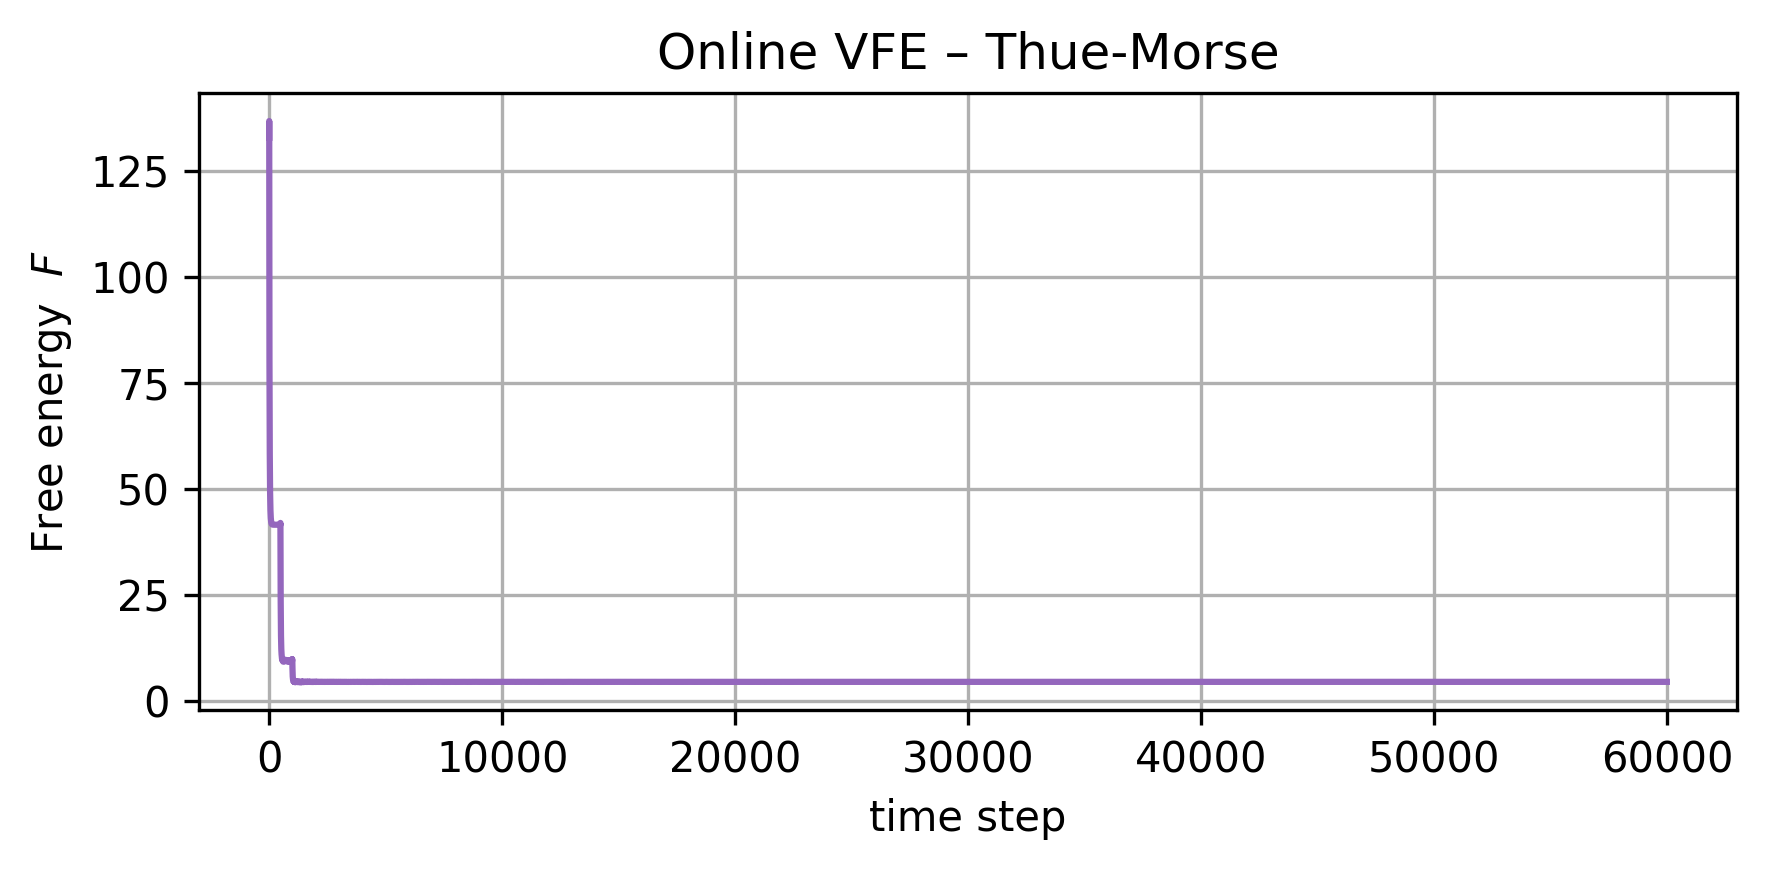

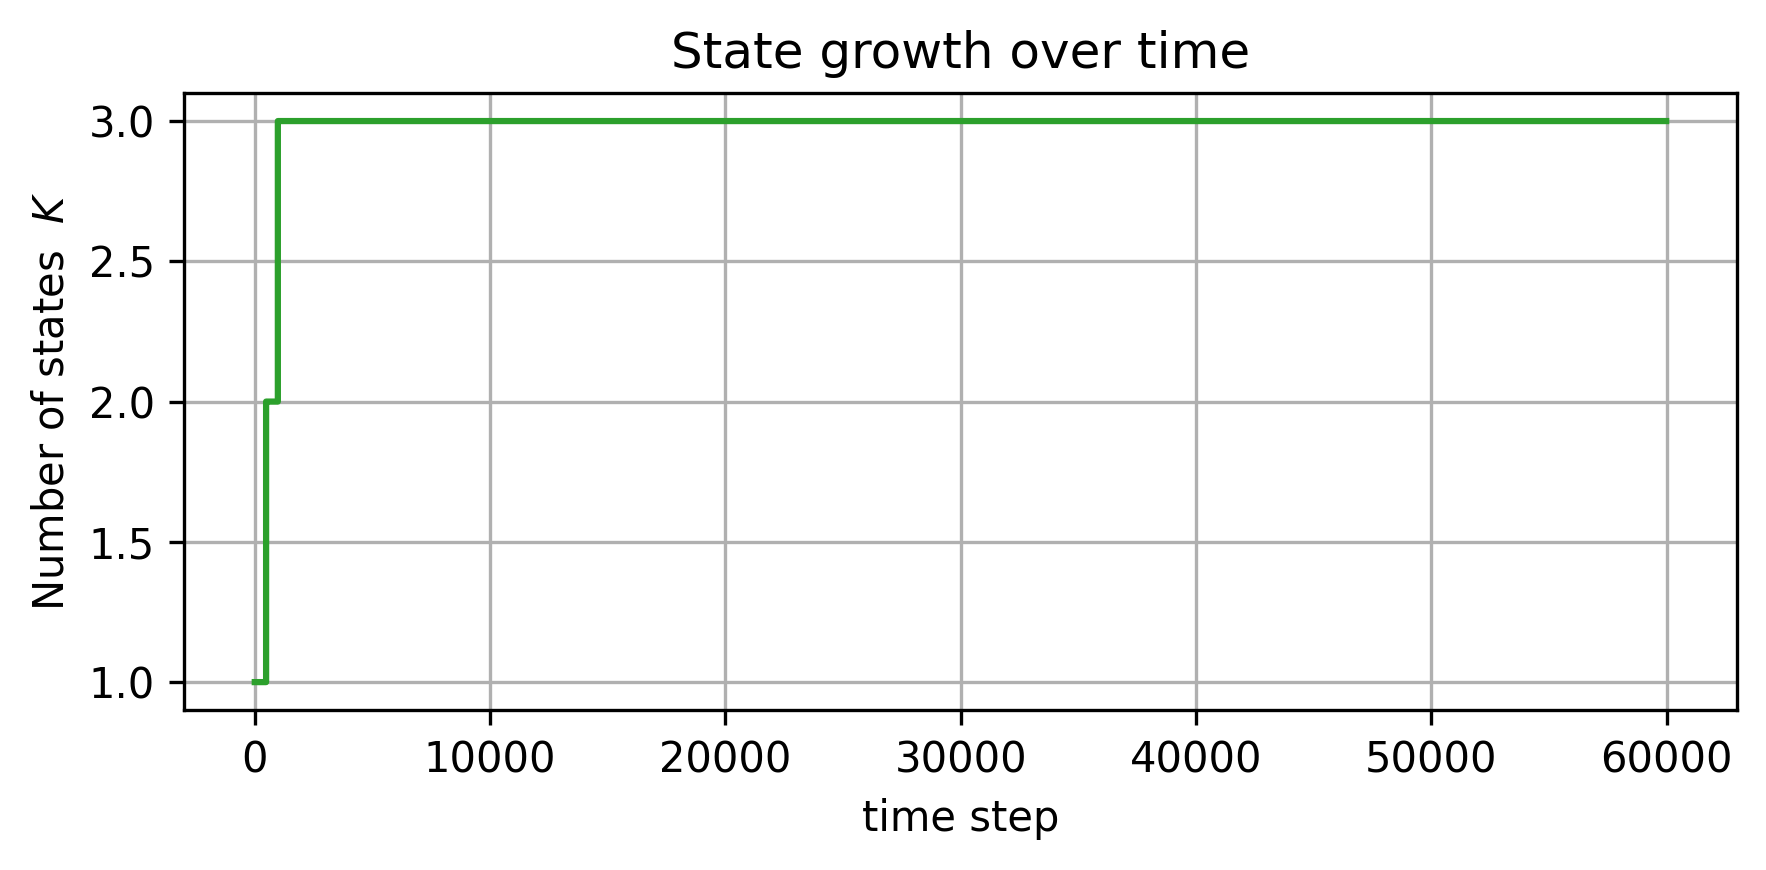

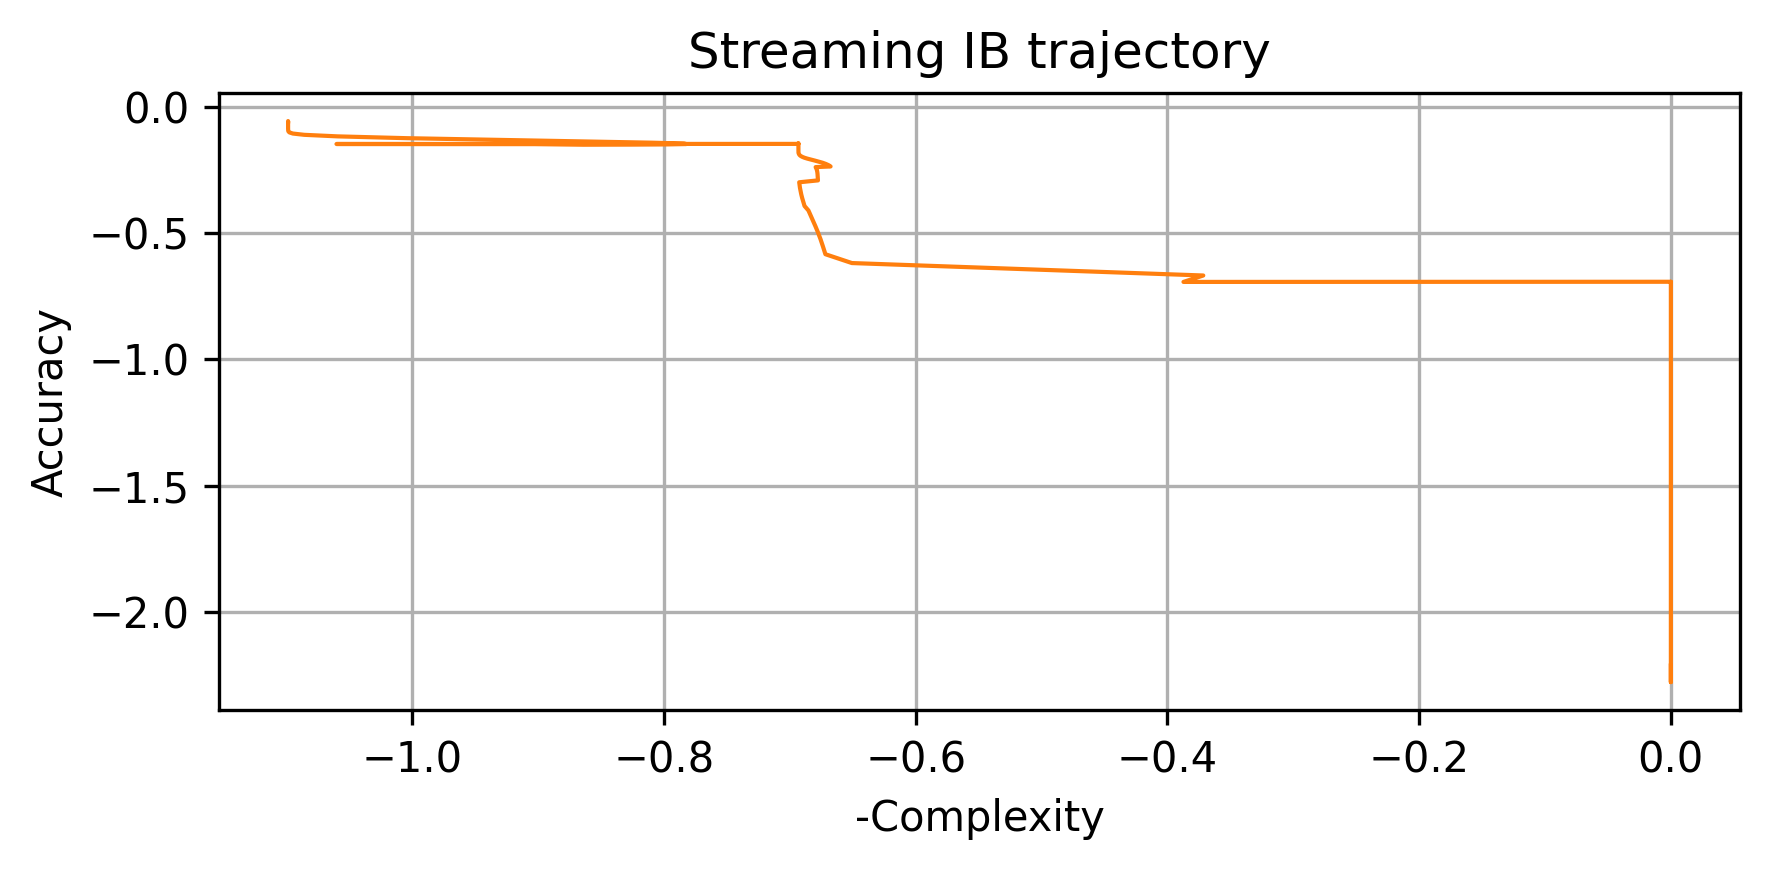

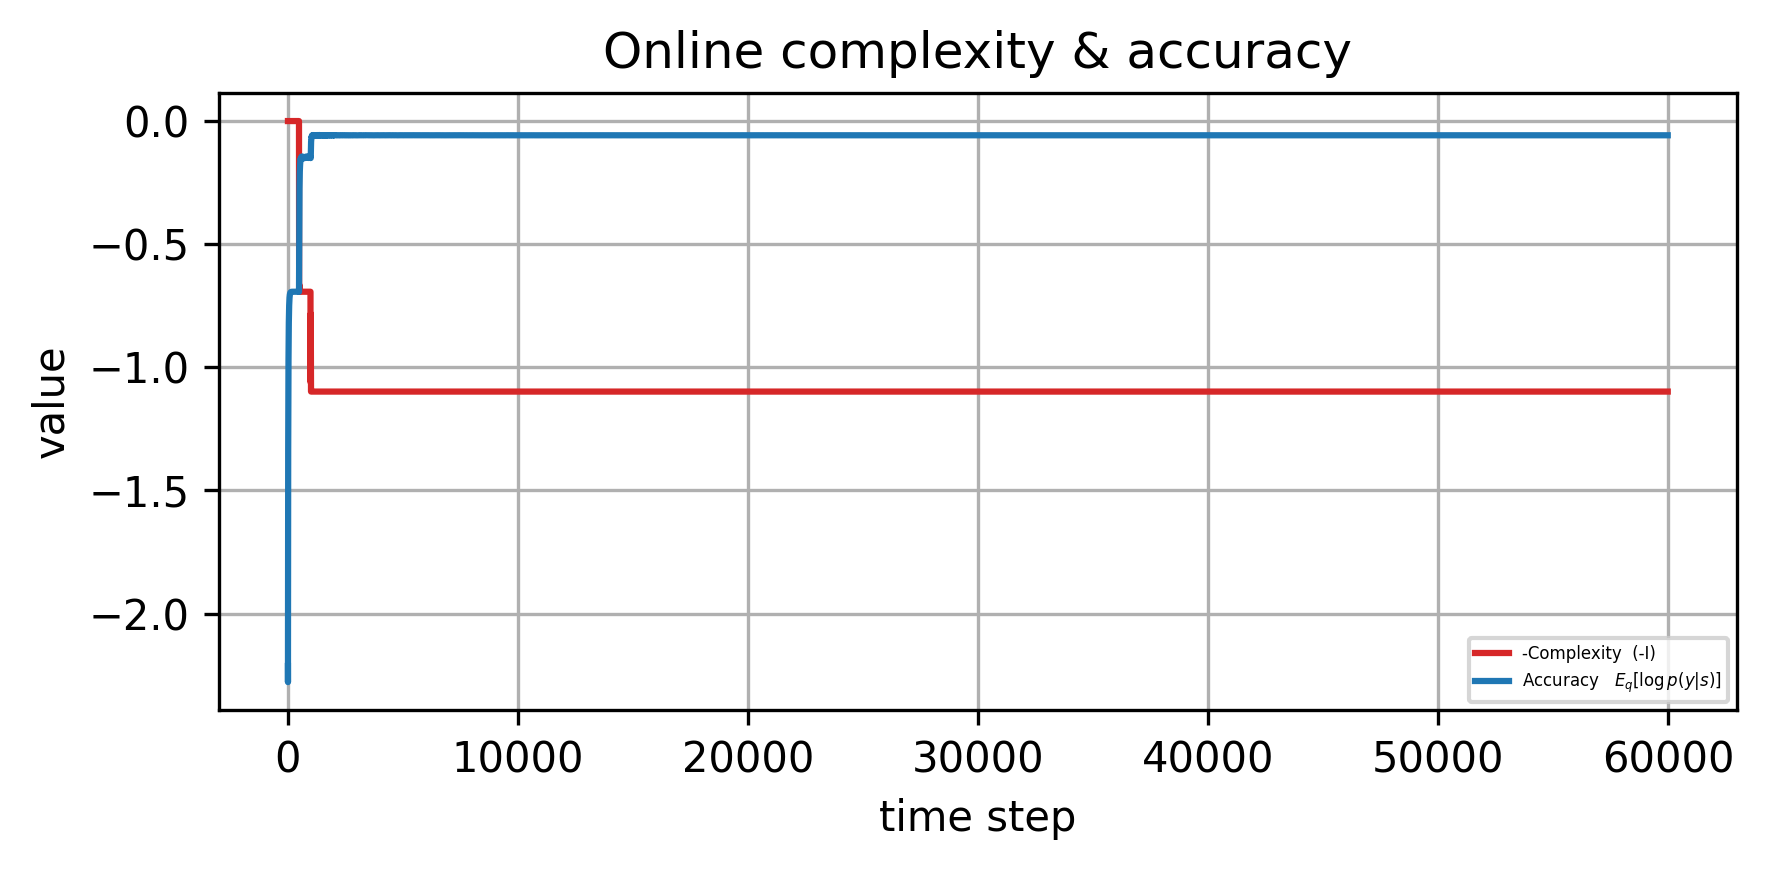

In [97]:
"""
Online Information-Bottleneck (streaming VFE)
============================================

* Incremental E→M update per symbol.
* Eigenvalue-based state splitting (Still 2014).
* Fixed or adaptive β (set beta_schedule if you want annealing).
* Live, publication-ready figures
      – Free energy F(t)
      – State count K(t)
      – Trajectory in IB plane (-complexity vs accuracy)
      – Complexity & accuracy time-series
"""

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ---------------------------------------------------------------------
# Colour palette (consistent across figures)
# ---------------------------------------------------------------------
COLORS = {
    'vfe'       : 'tab:purple',
    'complexity': 'tab:red',
    'accuracy'  : 'tab:blue',
    'states'    : 'tab:green',
    'ib'        : 'tab:orange',
}

# ---------------------------------------------------------------------
# 0.  Hyper-parameters
# ---------------------------------------------------------------------
past_window       = 20
future_window     = 4
alphabet_size     = 2 ** future_window

beta              = 60.0            # keep fixed, or anneal manually
forget_factor     = 1.0             # γ < 1 ⇒ exponential forgetting
learning_rate     = 0.05            # Robbins–Monro prototype smoothing
check_interval    = 500             # eigenvalue test cadence
delta_F_threshold = 0.01            # accept split if F drops ≥ this
max_states        = 12

np.random.seed(42)

# ---------------------------------------------------------------------
# 1.  Choose streaming source
# ---------------------------------------------------------------------
stream_name = "Thue-Morse"          # any key from PROCESSES
stream_gen  = PROCESSES[stream_name]
stream_data = stream_gen(60_000, seed=1)      # long stream to watch dynamics

# ---------------------------------------------------------------------
# 2.  Core helpers
# ---------------------------------------------------------------------
def kl(p, q, eps=1e-12):
    p, q = np.clip(p, eps, 1), np.clip(q, eps, 1)
    return float(np.sum(p * np.log(p / q)))

def free_energy(past_prob, posterior, emission, fut_given):
    k = posterior.shape[1]
    complexity = np.sum(past_prob[:, None] * posterior *
                        (np.log(posterior + 1e-12) + np.log(k)))
    accuracy   = np.sum(past_prob[:, None, None] * posterior[:, :, None] *
                        fut_given[:, None, :] *
                        np.log(emission[None, :, :] + 1e-12))
    return complexity - beta * accuracy, complexity, accuracy

def largest_eig(state_id, past_prob, posterior, emission, fut_given):
    diff   = fut_given - emission[state_id]              # N×A
    w      = past_prob * posterior[:, state_id]          # N
    cov    = (w[:, None] * diff).T @ diff               # A×A
    return np.linalg.eigvalsh(cov).max()

# ---------------------------------------------------------------------
# 3.  Streaming IB initialisation
# ---------------------------------------------------------------------
counts      = defaultdict(lambda: np.zeros(alphabet_size, float))
past_totals = defaultdict(float)

emission  = np.full((1, alphabet_size), 1/alphabet_size)   # start with 1 state
posterior = None

# logs for plots
F_log, comp_log, acc_log, state_log = [], [], [], []

# ---------------------------------------------------------------------
# 4.  Online processing loop
# ---------------------------------------------------------------------
past_buffer = list(stream_data[:past_window])   # sliding window seed

for t in range(past_window, len(stream_data)):
    ### ingest new symbol ------------------------------------------------
    y_t       = stream_data[t]
    past_idx  = int(''.join(map(str, past_buffer)), 2)

    # update empirical table with forgetting
    counts[past_idx]  *= forget_factor
    counts[past_idx][y_t] += 1
    past_totals[past_idx]  = past_totals[past_idx]*forget_factor + 1

    # current empirical P(y|past)
    P_y_given_past = {i: cnt / cnt.sum() for i, cnt in counts.items()}
    past_words     = sorted(P_y_given_past)
    past_prob      = np.array([past_totals[i] for i in past_words]); past_prob /= past_prob.sum()
    fut_given      = np.array([P_y_given_past[i] for i in past_words])

    ### E-step -----------------------------------------------------------
    dist  = np.array([[kl(fut_given[j], emission[k])
                       for k in range(emission.shape[0])]
                      for j in range(len(past_words))])
    posterior = np.exp(-beta * dist); posterior /= posterior.sum(1, keepdims=True)

    ### M-step  (stochastic) --------------------------------------------
    wght   = past_prob[:, None] * posterior
    target = (wght[:, :, None] * fut_given[:, None, :]).sum(0)
    target /= target.sum(1, keepdims=True)
    emission += learning_rate * (target - emission)

    ### log metrics ------------------------------------------------------
    F_t, C_t, A_t = free_energy(past_prob, posterior, emission, fut_given)
    F_log.append(F_t); comp_log.append(-C_t); acc_log.append(A_t)
    state_log.append(emission.shape[0])

    ### eigenvalue split every check_interval ---------------------------
    if (t % check_interval == 0) and (emission.shape[0] < max_states):
        lambdas = [largest_eig(k, past_prob, posterior, emission, fut_given)
                   for k in range(emission.shape[0])]
        k_star  = int(np.argmax(lambdas))
        if beta * lambdas[k_star] > 1.0:
            rng = np.random.default_rng(t)
            new_vec = emission[k_star] + rng.normal(scale=1e-2, size=alphabet_size)
            new_vec = np.clip(new_vec, 1e-6, None); new_vec /= new_vec.sum()
            emission = np.vstack([emission, new_vec[None, :]])

            posterior = np.pad(posterior, ((0,0),(0,1)), 'constant')
            posterior[:, -1] = posterior[:, k_star] * 0.5
            posterior[:, k_star] *= 0.5
            posterior /= posterior.sum(1, keepdims=True)

    ### slide window -----------------------------------------------------
    past_buffer.pop(0); past_buffer.append(y_t)

# ---------------------------------------------------------------------
# 5.  Figures
# ---------------------------------------------------------------------
steps = np.arange(len(F_log))

plt.figure(figsize=(6,3), dpi=300)
plt.plot(steps, F_log, color=COLORS['vfe'])
plt.xlabel('time step'); plt.ylabel('Free energy  $F$')
plt.title(f'Online VFE – {stream_name}'); plt.grid(True); plt.tight_layout()

plt.figure(figsize=(6,3), dpi=300)
plt.step(steps, state_log, where='post', color=COLORS['states'])
plt.xlabel('time step'); plt.ylabel('Number of states  $K$')
plt.title('State growth over time'); plt.grid(True); plt.tight_layout()

plt.figure(figsize=(6,3), dpi=300)
plt.plot(comp_log, acc_log, color=COLORS['ib'], lw=1)
plt.xlabel('-Complexity'); plt.ylabel('Accuracy')
plt.title('Streaming IB trajectory'); plt.grid(True); plt.tight_layout()

plt.figure(figsize=(6,3), dpi=300)
plt.plot(steps, comp_log, color=COLORS['complexity'], label='-Complexity  (-I)')
plt.plot(steps, acc_log,  color=COLORS['accuracy'],  label='Accuracy   $E_q[\\log p(y|s)]$')
plt.xlabel('time step'); plt.ylabel('value')
plt.title('Online complexity & accuracy')
plt.grid(True); plt.legend(); plt.tight_layout()

plt.show()